<a href="https://colab.research.google.com/github/mohammadRahimi1993/BigData/blob/main/EmbeddingClusteringClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture 
!pip install ampligraph; 

In [ ]:
%tensorflow_version 1.x 
import numpy as np
import pandas as pd
import ampligraph

ampligraph.__version__

TensorFlow 1.x selected.


'1.4.0'

In [ ]:
import requests
url = 'https://ampligraph.s3-eu-west-1.amazonaws.com/datasets/football_graph.csv'
open('football_results.csv', 'wb').write(requests.get(url).content)
df = pd.read_csv("football_results.csv").sort_values("date")
df.isna().sum()

date          0
home_team     0
away_team     0
home_score    2
away_score    2
tournament    0
city          0
country       0
neutral       0
dtype: int64

In [ ]:
df = df.dropna()
df["train"] = df.date < "2014-01-01"
df.train.value_counts()

True     35714
False     5057
Name: train, dtype: int64

In [ ]:
# Entities naming
df["match_id"] = df.index.values.astype(str)
df["match_id"] =  "Match" + df.match_id
df["city_id"] = "City" + df.city.str.title().str.replace(" ", "")
df["country_id"] = "Country" + df.country.str.title().str.replace(" ", "")
df["home_team_id"] = "Team" + df.home_team.str.title().str.replace(" ", "")
df["away_team_id"] = "Team" + df.away_team.str.title().str.replace(" ", "")
df["tournament_id"] = "Tournament" + df.tournament.str.title().str.replace(" ", "")
df["neutral"] = df.neutral.astype(str)

In [ ]:
triples = []
for _, row in df[df["train"]].iterrows():
    # Home and away information
    home_team = (row["home_team_id"], "isHomeTeamIn", row["match_id"])
    away_team = (row["away_team_id"], "isAwayTeamIn", row["match_id"])
    
    # Match results
    if row["home_score"] > row["away_score"]:
        score_home = (row["home_team_id"], "winnerOf", row["match_id"])
        score_away = (row["away_team_id"], "loserOf", row["match_id"])
    elif row["home_score"] < row["away_score"]:
        score_away = (row["away_team_id"], "winnerOf", row["match_id"])
        score_home = (row["home_team_id"], "loserOf", row["match_id"])
    else:
        score_home = (row["home_team_id"], "draws", row["match_id"])
        score_away = (row["away_team_id"], "draws", row["match_id"])
    home_score = (row["match_id"], "homeScores", np.clip(int(row["home_score"]), 0, 5))
    away_score = (row["match_id"], "awayScores", np.clip(int(row["away_score"]), 0, 5))
    
    # Match characteristics
    tournament = (row["match_id"], "inTournament", row["tournament_id"])
    city = (row["match_id"], "inCity", row["city_id"])
    country = (row["match_id"], "inCountry", row["country_id"])
    neutral = (row["match_id"], "isNeutral", row["neutral"])
    year = (row["match_id"], "atYear", row["date"][:4])
    
    triples.extend((home_team, away_team, score_home, score_away, 
                    tournament, city, country, neutral, year, home_score, away_score))

In [ ]:
triples_df = pd.DataFrame(triples, columns=["subject", "predicate", "object"])
triples_df[(triples_df.subject=="Match3129") | (triples_df.object=="Match3129")]

,subject,predicate,object
34419,TeamBrazil,isHomeTeamIn,Match3129
34420,TeamUruguay,isAwayTeamIn,Match3129
34421,TeamBrazil,loserOf,Match3129
34422,TeamUruguay,winnerOf,Match3129
34423,Match3129,inTournament,TournamentFifaWorldCup
34424,Match3129,inCity,CityRioDeJaneiro
34425,Match3129,inCountry,CountryBrazil
34426,Match3129,isNeutral,False
34427,Match3129,atYear,1950
34428,Match3129,homeScores,1


In [ ]:
from ampligraph.evaluation import train_test_split_no_unseen 
X_train, X_valid = train_test_split_no_unseen(np.array(triples), test_size=10000)
print('Train set size: ', X_train.shape)
print('Test set size: ', X_valid.shape)

Train set size:  (382854, 3)
Test set size:  (10000, 3)


In [ ]:
from ampligraph.latent_features import ComplEx
model = ComplEx(batches_count=50,
                epochs=300,
                k=100,
                eta=20,
                optimizer='adam', 
                optimizer_params={'lr':1e-4},
                loss='multiclass_nll',
                regularizer='LP', 
                regularizer_params={'p':3, 'lambda':1e-5}, 
                seed=0, 
                verbose=True)
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)
model.fit(X_train)
filter_triples = np.concatenate((X_train, X_valid))
from ampligraph.evaluation import evaluate_performance
ranks = evaluate_performance(X_valid,
                              model=model, 
                              filter_triples=filter_triples,
                              use_default_protocol=True,
                              verbose=True)
from ampligraph.evaluation import mr_score, mrr_score, hits_at_n_score

mr = mr_score(ranks)
mrr = mrr_score(ranks)

print("MRR: %.2f" % (mrr))
print("MR: %.2f" % (mr))

hits_10 = hits_at_n_score(ranks, n=10)
print("Hits@10: %.2f" % (hits_10))
hits_3 = hits_at_n_score(ranks, n=3)
print("Hits@3: %.2f" % (hits_3))
hits_1 = hits_at_n_score(ranks, n=1)
print("Hits@1: %.2f" % (hits_1))

Average ComplEx Loss:   0.242890: 100%|██████████| 300/300 [4:15:59<00:00, 51.20s/epoch]


WARNING - DeprecationWarning: use_default_protocol will be removed in future. Please use corrupt_side argument instead.


100%|██████████| 10000/10000 [30:51<00:00,  5.40it/s]


MRR: 0.30
MR: 2834.19
Hits@10: 0.42
Hits@3: 0.35
Hits@1: 0.22


In [ ]:
%%capture
!pip install seaborn adjustText
!git clone https://github.com/wyldebeast-wunderliebe/incf.countryutils.git
!pip install incf.countryutils/.

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from adjustText import adjust_text
from incf.countryutils import transformations
%matplotlib inline

In [ ]:
id_to_name_map = {**dict(zip(df.home_team_id, df.home_team)), **dict(zip(df.away_team_id, df.away_team))}

In [ ]:
teams = pd.concat((df.home_team_id[df["train"]], df.away_team_id[df["train"]])).unique()
team_embeddings = dict(zip(teams, model.get_embeddings(teams)))

In [ ]:
embeddings_2d = PCA(n_components=2).fit_transform(np.array([i for i in team_embeddings.values()]))

In [ ]:
from ampligraph.discovery import find_clusters
from sklearn.cluster import KMeans

clustering_algorithm = KMeans(n_clusters=6, n_init=50, max_iter=500, random_state=0)
clusters = find_clusters(teams, model, clustering_algorithm, mode='entity')

In [ ]:
def cn_to_ctn(country):
    try:
        return transformations.cn_to_ctn(id_to_name_map[country])
    except KeyError:
        return "unk"

In [ ]:
plot_df = pd.DataFrame({"teams": teams, 
                        "embedding1": embeddings_2d[:, 0], 
                        "embedding2": embeddings_2d[:, 1],
                        "continent": pd.Series(teams).apply(cn_to_ctn),
                        "cluster": "cluster" + pd.Series(clusters).astype(str)})

In [ ]:
top20teams = ["TeamBelgium", "TeamFrance", "TeamBrazil", "TeamEngland", "TeamPortugal", "TeamCroatia", "TeamSpain", 
              "TeamUruguay", "TeamSwitzerland", "TeamDenmark", "TeamArgentina", "TeamGermany", "TeamColombia",
              "TeamItaly", "TeamNetherlands", "TeamChile", "TeamSweden", "TeamMexico", "TeamPoland", "TeamIran"]

def plot_clusters(hue):
    np.random.seed(0)
    plt.figure(figsize=(12, 12))
    plt.title("{} embeddings".format(hue).capitalize())
    ax = sns.scatterplot(data=plot_df[plot_df.continent!="unk"], x="embedding1", y="embedding2", hue=hue)
    texts = []
    for i, point in plot_df.iterrows():
        if point["teams"] in top20teams or np.random.random() < 0.1:
            texts.append(plt.text(point['embedding1']+0.02, point['embedding2']+0.01, str(point["teams"])))
    adjust_text(texts)

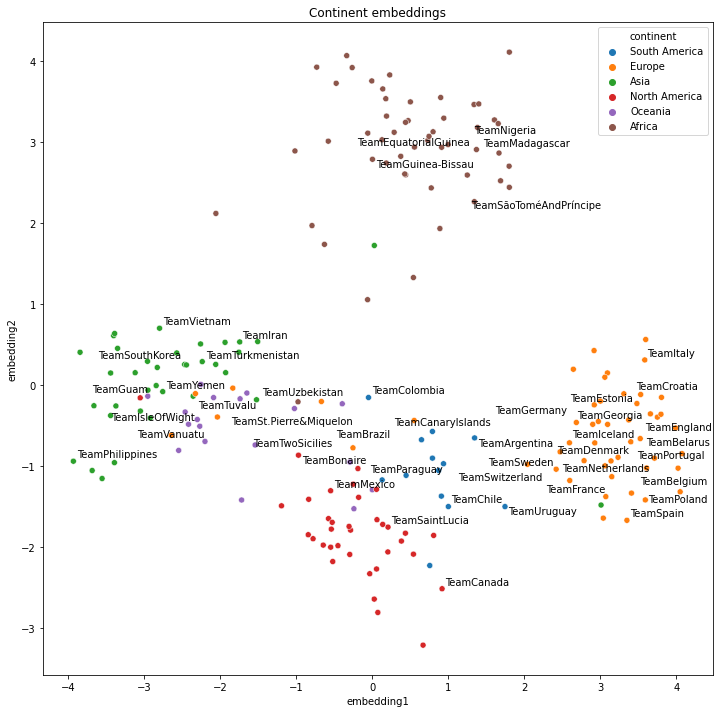

In [ ]:
plot_clusters("continent")

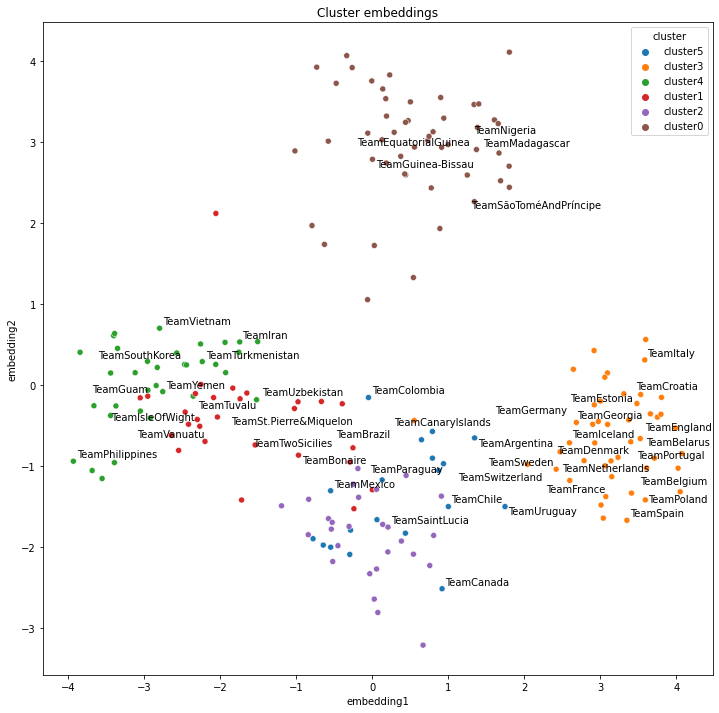

In [ ]:
plot_clusters("cluster")

In [ ]:
from sklearn import metrics
metrics.adjusted_rand_score(plot_df.continent, plot_df.cluster)

0.4863586386624455

In [ ]:
df["results"] = (df.home_score > df.away_score).astype(int) + \
                (df.home_score == df.away_score).astype(int)*2 + \
                (df.home_score < df.away_score).astype(int)*3 - 1

In [ ]:
df.results.value_counts(normalize=True)

0    0.486473
2    0.282456
1    0.231071
Name: results, dtype: float64

In [ ]:
def get_features_target(mask):
    
    def get_embeddings(team):
        return team_embeddings.get(team, np.full(200, np.nan))
    
    X = np.hstack((np.vstack(df[mask].home_team_id.apply(get_embeddings).values),
                   np.vstack(df[mask].away_team_id.apply(get_embeddings).values)))
    y = df[mask].results.values
    return X, y

In [ ]:
clf_X_train, y_train = get_features_target((df["train"]))
clf_X_test, y_test = get_features_target((~df["train"]))

In [ ]:
clf_X_train.shape, clf_X_test.shape

((35714, 400), (5057, 400))

In [ ]:
np.isnan(clf_X_test).sum()/clf_X_test.shape[1]

105.0

In [ ]:
%%capture
!pip install xgboost
from xgboost import XGBClassifier

In [ ]:
clf_model = XGBClassifier(n_estimators=500, max_depth=5, objective="multi:softmax")

In [ ]:
clf_model.fit(clf_X_train, y_train)

In [ ]:
df[~df["train"]].results.value_counts(normalize=True)

0    0.471030
2    0.287325
1    0.241645
Name: results, dtype: float64

In [32]:
metrics.accuracy_score(y_test, clf_model.predict(clf_X_test))

0.5400435040537869